## The ForestCover Dataset 

The original ForestCover/Covertype dataset from UCI machine learning repository is a multiclass classification dataset. It is used in predicting forest cover type from cartographic variables only (no remotely sensed data). This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. This dataset has 54 attributes (10 quantitative variables, 4 binary wilderness areas and 40 binary soil type variables). Here, outlier detection dataset is created using only 10 quantitative attributes. Instances from class 2 are considered as normal points and instances from class 4 are anomalies. The anomalies ratio is 0.9%. Instances from the other classes are omitted.

[resources](https://odds.cs.stonybrook.edu/forestcovercovertype-dataset/)

In [1]:
import os
import sys
from scipy.io import loadmat

import numpy as np
import pandas as pd
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.copod import COPOD
from pyod.models.suod import SUOD
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from sklearn.model_selection import train_test_split

from pyod.utils.data import evaluate_print, get_outliers_inliers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score


import matplotlib.pyplot as plt
import seaborn as sns


# Config
DATA_PATH = "../../datasets/cover.mat"

In [3]:
# Load the data
data = loadmat(DATA_PATH)

In [4]:
type(data)

dict

In [5]:
print(data.keys())
print(data['__version__'])
print(data['__header__'])
print(data['__globals__'])

print("*"*72)
print(data['X'])
print(data['y'])
print("*"*72)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
1.0
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 18 18:05:57 2016'
[]
************************************************************************
[[2804  139    9 ...  238  135 6121]
 [2785  155   18 ...  238  122 6211]
 [2579  132    6 ...  237  140 6031]
 ...
 [2612   17   13 ...  211  138  644]
 [2610   16   14 ...  211  138  671]
 [2608   23   14 ...  209  131  698]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
************************************************************************


In [6]:
X = data['X']
y = data['y']
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(286048, 10)
(286048, 1)


In [7]:
print(np.unique(y))

[0 1]


In [8]:
print(len(y[y==1]))
print(len(y[y==0]))

2747
283301


In [9]:
# The contamination percentage
print(len(y[y==1])/y.shape[0])

0.009603283365029646


Training LOF...
Training IForest...
Training AutoEncoder...


Training: 100%|██████████| 50/50 [14:05<00:00, 16.91s/it]


Training ABOD...
Training KNN...
Training COPOD...
Training SUOD...
RandomForestRegressor()



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
Training: 100%|██████████| 50/50 [51:44<00:00, 62.08s/it] 
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 52.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Evaluating LOF...
LOF ROC:1.0, precision @ rank n:1.0
Evaluating IForest...
IForest ROC:1.0, precision @ rank n:1.0
Evaluating AutoEncoder...
AutoEncoder ROC:1.0, precision @ rank n:1.0
Evaluating ABOD...
ABOD ROC:1.0, precision @ rank n:1.0
Evaluating KNN...
KNN ROC:1.0, precision @ rank n:1.0
Evaluating COPOD...
COPOD ROC:1.0, precision @ rank n:1.0
Evaluating SUOD...
SUOD ROC:1.0, precision @ rank n:1.0


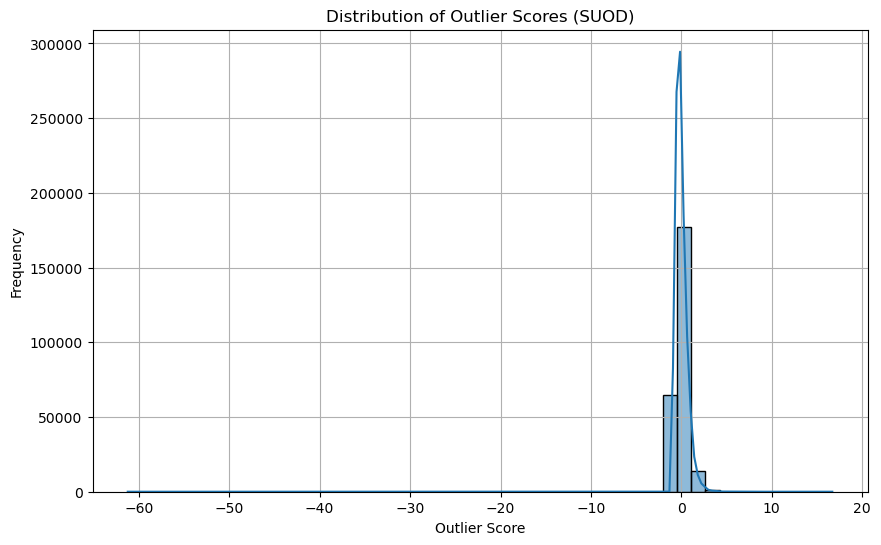

In [11]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=2):
    # Preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the dataset (optional, as this is unsupervised)
    X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)
    
    # Initialize outlier detectors
    detectors = [
        ('LOF', LOF(n_neighbors=20)),
        ('IForest', IForest(n_estimators=100, contamination=0.009)),
        # ('OCSVM', OCSVM(contamination=0.009)),
        ('AutoEncoder', AutoEncoder(contamination=0.009, hidden_neuron_list=[64, 32], epoch_num=50, batch_size=32)),
        ('ABOD', ABOD(contamination=0.1)),
        ('KNN', KNN(n_neighbors=5, contamination=0.009)),
        ('COPOD', COPOD(contamination=0.009))
    ]
    
    # Initialize SUOD with all detectors
    suod = SUOD(base_estimators=[det[1] for det in detectors], contamination=0.009, n_jobs=2)
    
    # Train all detectors
    for name, detector in detectors:
        print(f'Training {name}...')
        detector.fit(X_train)
    
    # Train SUOD
    print('Training SUOD...')
    suod.fit(X_train)
    
    # Predict and evaluate for each detector
    for name, detector in detectors:
        print(f'Evaluating {name}...')
        y_train_pred = detector.labels_                      # binary labels (0: inliers, 1: outliers)
        y_train_scores = detector.decision_scores_           # raw outlier scores
        evaluate_print(name, y_train_pred, y_train_scores)
    
    
    # Predict and evaluate for SUOD
    print('Evaluating SUOD...')
    y_train_pred = suod.labels_
    y_train_scores = suod.decision_scores_
    evaluate_print('SUOD',
                   y_train_pred,
                   y_train_scores)
    
    
    # Plot the distribution of outlier scores for one of the models
    plt.figure(figsize=(10, 6))
    sns.histplot(y_train_scores, bins=50, kde=True)
    plt.title("Distribution of Outlier Scores (SUOD)")
    plt.xlabel("Outlier Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [ ]:


# Load the ForestCover dataset
data_path = 'path_to_your_ForestCover_dataset.csv'
df = pd.read_csv(data_path)

# Initial Data Inspection
print("Dataset Overview:")
print(df.head())
print(f"Shape of dataset: {df.shape}")
print("Data types and missing values:")
print(df.info())

# Handle missing data if necessary
if df.isnull().sum().sum() > 0:
    print("Handling missing data...")
    df.fillna(df.mean(), inplace=True)

# Handle categorical features if necessary
# Assuming 'Cover_Type' is the label, and it's a categorical feature
label_encoder = LabelEncoder()
df['Cover_Type'] = label_encoder.fit_transform(df['Cover_Type'])

# Drop the label column to focus on outlier detection
X = df.drop(columns=['Cover_Type'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: Split the dataset into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)

# Initialize outlier detectors
detectors = [
    ('LOF', LOF(n_neighbors=20)),
    ('IForest', IForest(n_estimators=100, contamination=0.1)),
    ('OCSVM', OCSVM(contamination=0.1)),
    ('AutoEncoder', AutoEncoder(contamination=0.1, hidden_neuron_list=[64, 32], epochs=50, batch_size=32, verbose=0)),
    ('ABOD', ABOD(contamination=0.1)),
    ('KNN', KNN(n_neighbors=5, contamination=0.1)),
    ('COPOD', COPOD(contamination=0.1))
]

# Initialize SUOD with all detectors
suod = SUOD(base_estimators=[det[1] for det in detectors], contamination=0.1, n_jobs=2)

# Train and evaluate each detector
results = {}
for name, detector in detectors:
    print(f"Training {name}...")
    detector.fit(X_train)
    
    print(f"Evaluating {name}...")
    y_train_pred = detector.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = detector.decision_scores_  # raw outlier scores
    
    # Calculate additional evaluation metrics
    precision, recall, f1 = precision_score(y_train_pred, y_train_scores), recall_score(y_train_pred, y_train_scores), f1_score(y_train_pred, y_train_scores)
    roc_auc = roc_auc_score(y_train_pred, y_train_scores)
    precision_recall_auc = auc(*precision_recall_curve(y_train_pred, y_train_scores)[:2])
    
    results[name] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'precision_recall_auc': precision_recall_auc
    }
    
    print(f"Metrics for {name}:")
    evaluate_print(name, y_train_pred, y_train_scores)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Precision-Recall AUC: {precision_recall_auc:.4f}")
    print("="*60)

# Train and evaluate SUOD
print('Training SUOD...')
suod.fit(X_train)

print('Evaluating SUOD...')
y_train_pred = suod.labels_
y_train_scores = suod.decision_scores_

# Calculate additional evaluation metrics for SUOD
precision, recall, f1 = precision_score(y_train_pred, y_train_scores), recall_score(y_train_pred, y_train_scores), f1_score(y_train_pred, y_train_scores)
roc_auc = roc_auc_score(y_train_pred, y_train_scores)
precision_recall_auc = auc(*precision_recall_curve(y_train_pred, y_train_scores)[:2])

results['SUOD'] = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'precision_recall_auc': precision_recall_auc
}

evaluate_print('SUOD', y_train_pred, y_train_scores)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Precision-Recall AUC: {precision_recall_auc:.4f}")

# Visualization of outlier scores
plt.figure(figsize=(12, 8))
sns.histplot(y_train_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores (SUOD)")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot outliers vs inliers
def plot_outliers_vs_inliers(X, y_pred, plot_features):
    plt.figure(figsize=(14, 8))
    plt.scatter(X[y_pred == 0, plot_features[0]], X[y_pred == 0, plot_features[1]], color='blue', label='Inliers', alpha=0.6)
    plt.scatter(X[y_pred == 1, plot_features[0]], X[y_pred == 1, plot_features[1]], color='red', label='Outliers', alpha=0.6)
    plt.xlabel(f'Feature {plot_features[0] + 1}')
    plt.ylabel(f'Feature {plot_features[1] + 1}')
    plt.title('Outliers vs Inliers')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select two features for visualization
plot_outliers_vs_inliers(X_train, y_train_pred, plot_features=[0, 1])

# Display results summary
print("Summary of Results:")
for name, metrics in results.items():
    print(f"{name} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1_score']:.4f}, ROC AUC: {metrics['roc_auc']:.4f}, Precision-Recall AUC: {metrics['precision_recall_auc']:.4f}")